# MSEED File Size Predictions
In this notebook I will be generating a regression model to model the file sizes of mseed files based on the number of traces and the sampling rate.

Author: Shivansh Baveja
Contact: shivansh.baveja@berkeley.edu or sbaveja@mit.edu

I will begin by sampling various data points of different #'s of traces and sampling rates. I will be using the station XH : RS07.

In [3]:
# basic imports
from obspy.clients.fdsn import Client
from obspy import read
import obspy
import numpy as np
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import matplotlib as mplt
import os
from sklearn.linear_model import LinearRegression
from IPython.display import Markdown as md
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

%matplotlib notebook

In [4]:
# retrieve the data shown from certain dates
# I will be using a constant data frame length of 1 day.
starttime = UTCDateTime('2015-01-22T00:00:00')
endtime = starttime + 60*60*24

# find parameters for data query
client = Client('IRIS')
net = 'XH'
sta = 'RS07'
loc = '--'

# query for data
st_1T1H = client.get_waveforms(net, sta, loc, 'LHE', starttime, endtime, attach_response = True)
st_1T20H = client.get_waveforms(net, sta, loc, 'BHE', starttime, endtime, attach_response = True)
st_1T100H = client.get_waveforms(net, sta, loc, 'HHE', starttime, endtime, attach_response = True)

st_1T1H2 = client.get_waveforms(net, sta, loc, 'LHN', starttime, endtime, attach_response = True)
st_1T20H2 = client.get_waveforms(net, sta, loc, 'BHN', starttime, endtime, attach_response = True)
st_1T100H2 = client.get_waveforms(net, sta, loc, 'HHN', starttime, endtime, attach_response = True)

st_3T1H = client.get_waveforms(net, sta, loc, 'LH*', starttime, endtime, attach_response = True)
st_3T20H = client.get_waveforms(net, sta, loc, 'BH*', starttime, endtime, attach_response = True)
st_3T100H = client.get_waveforms(net, sta, loc, 'HH*', starttime, endtime, attach_response = True)

In [5]:
# defining the two trace streams
st_2T1H = st_1T1H + st_1T1H2
st_2T20H = st_1T20H + st_1T20H2
st_2T100H = st_1T100H + st_1T100H2

We will first write a 1 day long sample sampled at 1 Hz.

In [6]:
# making sure that all the streams have been parsed correctly

In [7]:
print(st_1T1H)
print(st_1T20H)
print(st_1T100H)
print(st_2T1H)
print(st_2T20H)
print(st_2T100H)
print(st_3T1H)
print(st_3T20H)
print(st_3T100H)

1 Trace(s) in Stream:
XH.RS07..LHE | 2015-01-22T00:00:00.000001Z - 2015-01-23T00:00:00.000001Z | 1.0 Hz, 86401 samples
1 Trace(s) in Stream:
XH.RS07..BHE | 2015-01-22T00:00:00.000001Z - 2015-01-23T00:00:00.000001Z | 20.0 Hz, 1728001 samples
1 Trace(s) in Stream:
XH.RS07..HHE | 2015-01-22T00:00:00.000001Z - 2015-01-23T00:00:00.000001Z | 100.0 Hz, 8640001 samples
2 Trace(s) in Stream:
XH.RS07..LHE | 2015-01-22T00:00:00.000001Z - 2015-01-23T00:00:00.000001Z | 1.0 Hz, 86401 samples
XH.RS07..LHN | 2015-01-22T00:00:00.000000Z - 2015-01-22T23:59:59.000000Z | 1.0 Hz, 86400 samples
2 Trace(s) in Stream:
XH.RS07..BHE | 2015-01-22T00:00:00.000001Z - 2015-01-23T00:00:00.000001Z | 20.0 Hz, 1728001 samples
XH.RS07..BHN | 2015-01-22T00:00:00.000001Z - 2015-01-23T00:00:00.000001Z | 20.0 Hz, 1728001 samples
2 Trace(s) in Stream:
XH.RS07..HHE | 2015-01-22T00:00:00.000001Z - 2015-01-23T00:00:00.000001Z | 100.0 Hz, 8640001 samples
XH.RS07..HHN | 2015-01-22T00:00:00.000000Z - 2015-01-23T00:00:00.000000Z | 

In [8]:
# saving all of the data to view file sizes
st_1T1H.write(filename='Data/1T1H.mseed', format="MSEED")
st_1T20H.write(filename='Data/1T20H.mseed', format="MSEED")
st_1T100H.write(filename='Data/1T100H.mseed', format="MSEED")
st_2T1H.write(filename='Data/2T1H.mseed', format="MSEED")
st_2T20H.write(filename='Data/2T20H.mseed', format="MSEED")
st_2T100H.write(filename='Data/2T100H.mseed', format="MSEED")
st_3T1H.write(filename='Data/3T1H.mseed', format="MSEED")
st_3T20H.write(filename='Data/3T20H.mseed', format="MSEED")
st_3T100H.write(filename='Data/3T100H.mseed', format="MSEED")

In [9]:
# storing filesizes in bytes

# independent variable pairs are (# traces, sampling rate)
X = []
y = []

X.append([1,1])
X.append([1,20])
X.append([1,100])

X.append([2,1])
X.append([2,20])
X.append([2,100])

X.append([3,1])
X.append([3,20])
X.append([3,100])

y.append(os.path.getsize('Data/1T1H.mseed'))
y.append(os.path.getsize('Data/1T20H.mseed'))
y.append(os.path.getsize('Data/1T100H.mseed'))

y.append(os.path.getsize('Data/2T1H.mseed'))
y.append(os.path.getsize('Data/2T20H.mseed'))
y.append(os.path.getsize('Data/2T100H.mseed'))

y.append(os.path.getsize('Data/3T1H.mseed'))
y.append(os.path.getsize('Data/3T20H.mseed'))
y.append(os.path.getsize('Data/3T100H.mseed'))

X = np.array(X)
y = np.array(y)

# scale y values to mb
y = y/(1000000.)

In [56]:
# print(X)
print(y)
print()
print(y_pred)

[ 0.1024    1.110016  6.029312  0.217088  2.322432 11.718656  0.339968
  3.608576 17.149952]

[ 0.05004741  1.13893104  6.05274955  0.23938844  2.36657778 11.65220978
  0.37002014  3.53551518 17.19296067]


In [11]:
# performing the linear regression
reg = LinearRegression().fit(X, y)

print("coef: " + str(reg.coef_))
print("intercept: " + str(reg.intercept_))

coef: [2.30946133 0.11551361]
intercept: -4.544816195145515


We can interpret these coeff as saying that for a 1 Day period, madding 1 trace adds ~2.31 mb and increasing the sampling rate by 1 Hz adds ~0.115 mb of data.

<IPython.core.display.Javascript object>


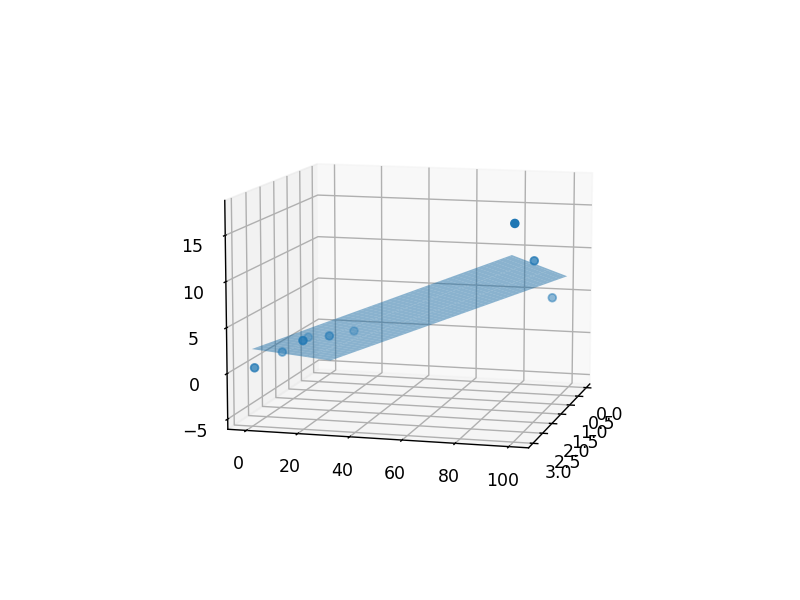

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.view_init(10, 15)
# print(X[:,1])
ax.scatter(X[:,0], X[:,1],y)

In [13]:
# plotting the plane
xx, yy = np.meshgrid(range(4), range(100))
z = (reg.intercept_ + reg.coef_[0]*xx + reg.coef_[1]*yy) 
ax.plot_surface(xx, yy, z, alpha=0.5)

In [14]:
reg.score(X,y)

0.8846091433886151

With an $R^2$ of 0.884, this isn't a great regression, but is relatively good. We can use the following formula to find the number of mb in an mseed file holding data for one day, where s = sampling rate in Hz, and t = # of traces.

$$d = 2.30946133 \cdot t + 0.11551361 \cdot s - -4.544$$

Upon doing this, we see the intercept term really doesn't make sense if you have a stream with one trace of data at 1 Hz, the model is predicting you will need negative storage. Thus, we will attempt a polynomial regression.

# Polynomial Regression

In [15]:
df = pd.DataFrame({"x_1":X[:,0], "x_2":X[:,1], "y":y}, index=range(0,9))

In [51]:
df

,x_1,x_2,y
0,1,1,0.102400
1,1,20,1.110016
2,1,100,6.029312
3,2,1,0.217088
4,2,20,2.322432
5,2,100,11.718656
6,3,1,0.339968
7,3,20,3.608576
8,3,100,17.149952


In [62]:
poly_reg=PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X)
poly_reg.fit(X_poly,y)

linreg = LinearRegression()
linreg.fit(X_poly, y)
y_pred = linreg.predict(X_poly)

print(y_pred)
print(linreg.coef_)

[ 0.05004741  1.13893104  6.05274955  0.23938844  2.36657778 11.65220978
  0.37002014  3.53551518 17.19296067]
[ 0.00000000e+00  2.22757365e-01  1.78952737e-03 -2.93546667e-02
  5.46476686e-02  4.15461279e-05]


In [53]:
poly_reg.get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x0^2', 'x0 x1', 'x0 x2',
       'x0 x3', 'x0 x4', 'x0 x5', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4',
       'x1 x5', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x3^2', 'x3 x4',
       'x3 x5', 'x4^2', 'x4 x5', 'x5^2'], dtype=object)

<IPython.core.display.Javascript object>


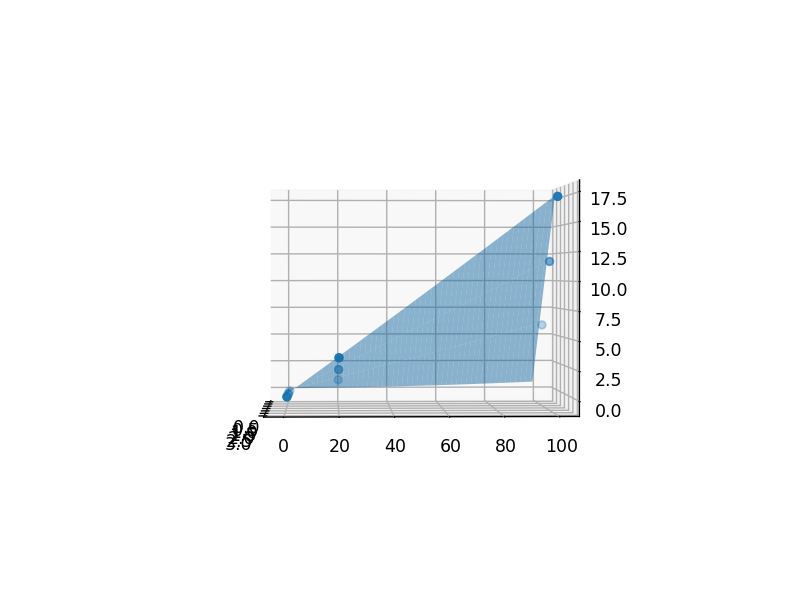

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.view_init(10, 15)
# print(X[:,1])
ax.scatter(X[:,0], X[:,1],y)

In [55]:
# plotting the plane
x0 = xx
x1 = yy
coef = linreg.coef_

xx, yy = np.meshgrid(range(4), range(100))
z = (1 * coef[0]) + (x0 * coef[1]) + (x1 * coef[2]) + (x0**2 * coef[3]) + (x0 * x1 * coef[4]) + (x1 ** 2 * coef[5])
x0 = X[:,0]
x1 = X[:,1]

ax.plot_surface(xx, yy, z, alpha=0.5)
# surf = ax.plot_trisurf(X[:,0], X[:,1], z, linewidth=0, antialiased=False, cmap='Greens')

In [21]:
linreg.score(X_poly,y)

0.999933292110271

In [22]:
linreg.coef_

array([ 0.00000000e+00,  2.22757365e-01,  1.78952737e-03, -2.93546667e-02,
        5.46476686e-02,  4.15461279e-05])

With an $R^2$ of 0.99, this is great. We can use the following formula to find the number of mb in an mseed file holding data for one day, where s = sampling rate in Hz, and t = # of traces.

$$d = 0.222757 \cdot t + 0.001789 \cdot s -0.029354 \cdot t^2 + 0.0546 \cdot s \cdot t + 0.00004154 \cdot s^2$$
